## This is a Simulated Process dataset with faults - used as a trial version related to a paper machine paper break dataset, although fewer features and far fewer samples.

### This version uses the simulated sensor positions as well as the single and double derivatives imitating a 'velocity' and 'acceleration' of sensor position.  The EDA and descriptions are included here as well as in the base case only using the simulated sendor values. 

#### The business case is simple: Identifying a likely fault before it occurs is intended to give time to adjust the process to avoid the condition which will improve production, efficiency, and reduce cost of downtime.

The dataset has two classes, normal or running (0) and fault or stopped (1).

These Classes are ammended to reflec the likelihood of an impending fault and are set to 2 at a fault.  Prior samples are set to class 1 to represent a warning state.

The assumption is that the process conditions change enough prior to the fault to detect the condition, even if they appear to be within a normal range or deviation is consistent in one direction ths leading to the fault.  This is the case with this simulated dataset.  In addition there are deviations modelled between faults that do not progress to the point of failure.  Of nterest is if these will be classified as a warning even though there is no fault associated with them and thus the class relabelling will miss these deviations.

The sample process values continue at a normal state after a fault.  There isn't a simulated time for restart or restoring the process.  The samples only simulate running state leading to a fault condition.



### Workflow:  
Import train and test dataset and set a probability class of future or impending fault to the samples prior to the failure.  

Scale the dataset and build a numpy array of 'images' to have 6 time samples per image.  The first image will be samples 0 to 5.  The second will be sample 1 to 6 and so on.  The image sequence resets at a fault, when the last sample in the image is a fault.  Therefore the number of images is the number of samples less 5 for each fault sample.  In this simulated dataset, the last sample is a fault.


In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import livelossplot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('Simulated_Process_with_Faults.csv')
df_t = pd.read_csv('Simulated_Test.csv')

#### Examine the simulated dataset of process values and the faults under the 'Y' feature.

<Figure size 1152x720 with 0 Axes>

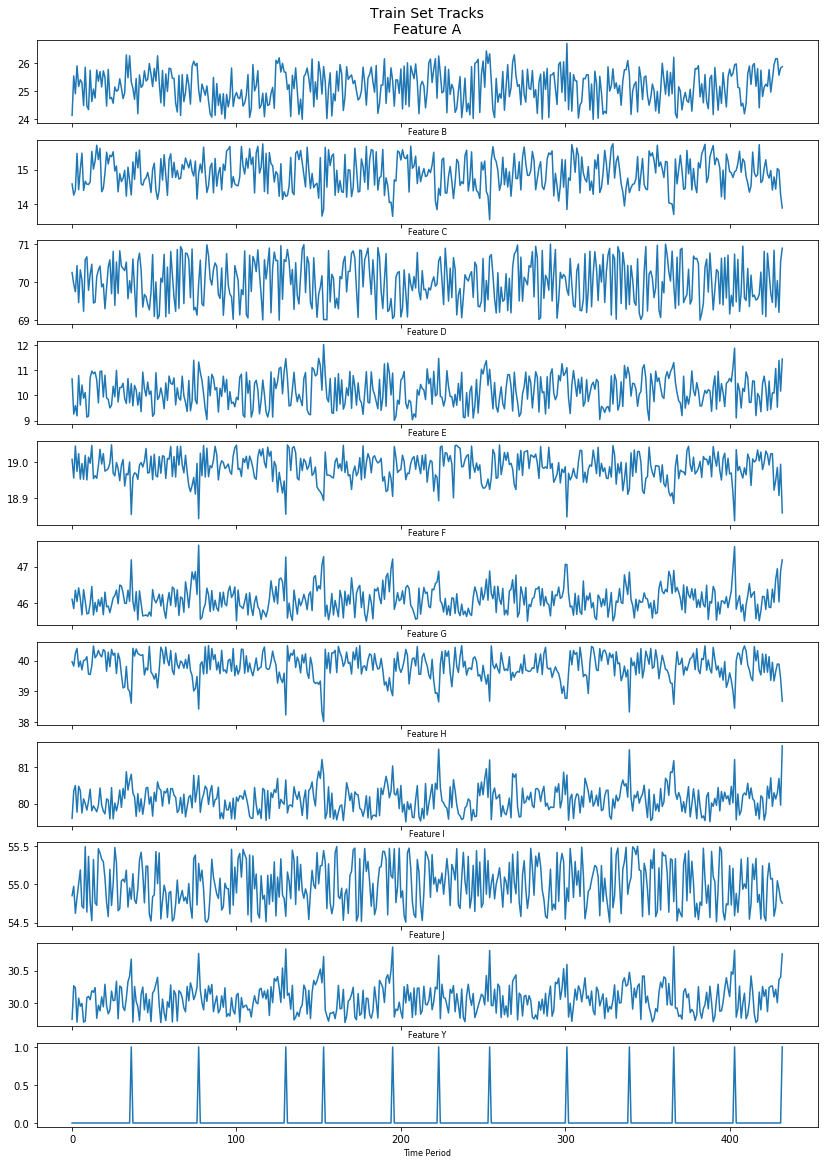

In [3]:
Features = ['A','B','C','D','E','F','G','H','I','J','Y']
fig = plt.figure(figsize = (16,10))
fig,(ax)  = plt.subplots(11, 1, figsize = (14, 20), sharex = True )
for i in range(11):
    ax[i].plot(df[Features[i]])
    #ax[i].plot(df_t[Features[i]])
    if i == 0:
        ax[i].set_title("Train Set Tracks\nFeature " + Features[i], size=14)
    else:
        ax[i].set_title("Feature " + Features[i], size=8)
plt.xlabel('Time Period', size=8)
plt.show()

<Figure size 1152x720 with 0 Axes>

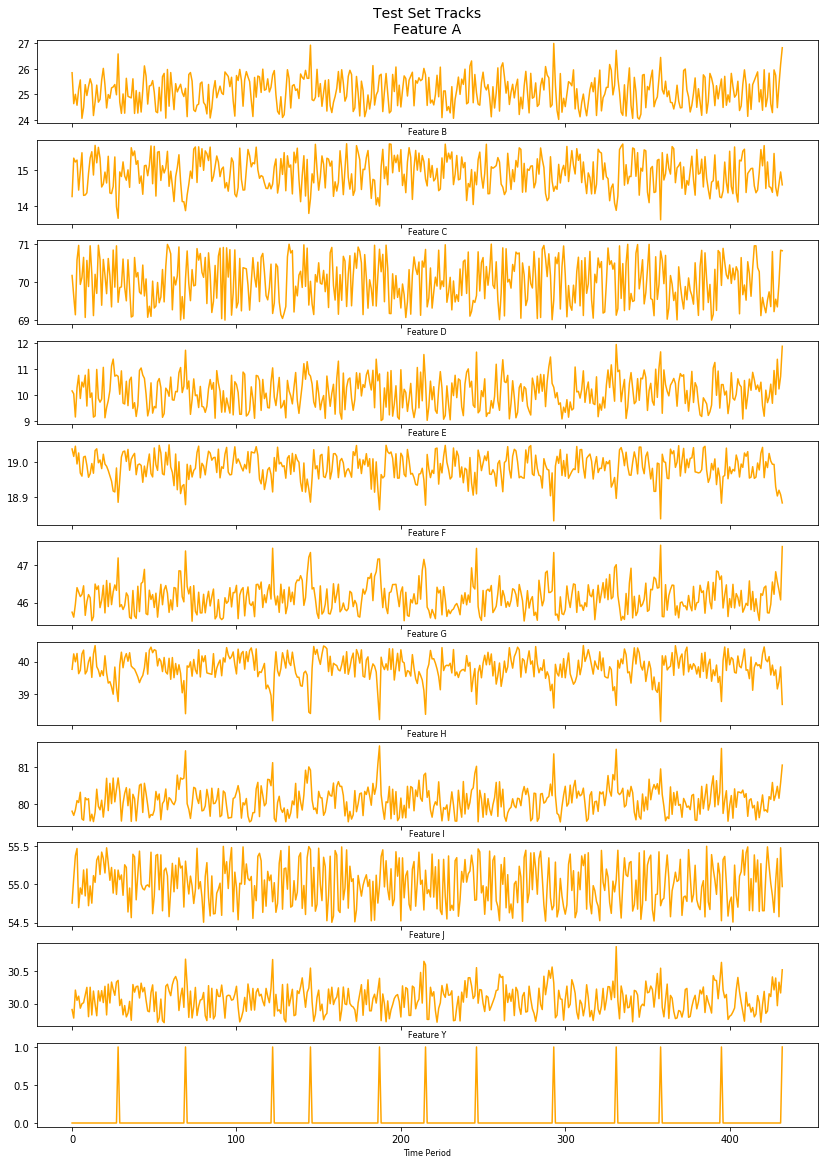

In [4]:
Features = ['A','B','C','D','E','F','G','H','I','J','Y']
fig = plt.figure(figsize = (16,10))
fig,(ax)  = plt.subplots(11, 1, figsize = (14, 20), sharex = True )
for i in range(11):
    #ax[i].plot(df[Features[i]])
    ax[i].plot(df_t[Features[i]], c = 'orange' )
    if i == 0:
        ax[i].set_title("Test Set Tracks\nFeature " + Features[i], size=14)
    else:
        ax[i].set_title("Feature " + Features[i], size=8)
plt.xlabel('Time Period', size=8)
plt.show()

Visually we can see the faults in the simulated process measurement.  These are created with a bias, and a random variation plus/minus a secondary bias multiplied by a weight from 0.1 to 1.0.  The weight increases for 0.1 to 0.4 at varying rates before jumping to 1.0.  At 1.0 there is a fault.  

The objective is to identify deviation trends from normal indicating an impending fault, thus allowing operators, or operating system to take action.

Features 'B' and 'I' do not have a secondary bias.  The other do have a bias but not necessarily greater than the range of the normal process noise, but applying in a single direction (plus or minus) versus the random process values variation.
The secondary bias is applied at lower values periodically between the faults as well, simulating a deviating process that returns without experiencing a fault.  These points are not identified under the 'Y' feature, but may be predicted by the model.

#### Build two derivative df's 'velocity' and 'acceleration'.  Assume unit time interval between samples.

In [5]:
#Build a function to create a derivative sample set
def RateOfChange (df1, y_name):
    df_out = pd.DataFrame(columns=df1.columns)
    df_out[y_name] = df1[y_name]
    df_out.iloc[0,0:-1] = 0
    df_out.iloc[1:,0:-1] = (np.array( df1.iloc[1:,0:-1]) - np.array( df1.iloc[0:-1,0:-1]) )/1
    return (df_out)

In [6]:
# Training set 'velocity'
df_v = RateOfChange(df, 'Y')

# Test set 'velocity'
df_vt = RateOfChange(df_t, 'Y')

# Training set 'acceleration'
df_a = RateOfChange(df_v, 'Y')

# Test set 'acceleration'
df_at = RateOfChange(df_vt, 'Y')

In [7]:
# Drop Y value
df_p = df.drop('Y', axis = 1)
df_v = df_v.drop('Y', axis = 1)
df_a = df_a.drop('Y', axis = 1)

In [8]:
# Drop Y value
df_pt = df_t.drop('Y', axis = 1)
df_vt = df_vt.drop('Y', axis = 1)
df_at = df_at.drop('Y', axis = 1)

In [9]:
# Scale the data.  Scaling from 0 to 1 will also allow for image show of grouped samples.
scaler = MinMaxScaler()

df_p=scaler.fit_transform(df_p)
df_pt=scaler.fit_transform(df_pt)

df_v=scaler.fit_transform(df_v)
df_vt=scaler.fit_transform(df_vt)

df_a=scaler.fit_transform(df_a)
df_at=scaler.fit_transform(df_at)

In [10]:
# Check
df_p.min(), df_p.max(), df_v.min(), df_v.max(), df_a.min(), df_a.max()

(0.0, 1.0000000000000018, 0.0, 1.0000000000000002, 0.0, 1.0)

In [11]:
# Check
df_pt.min(), df_pt.max(), df_vt.min(), df_vt.max(), df_at.min(), df_at.max()

(0.0, 1.0000000000000004, 0.0, 1.0, 0.0, 1.0)

## Now build the image dataset.
### There are fewer samples in the image set, 373 vs 433. So the Classification labels need to be rebuilt with the images.

In [12]:
image_count = len(df_p)-5*df['Y'].sum()
image_count

373

In [13]:
# Re-Build Image set with Y labels as 1 for images 5 time periods and less in advance of actual failure.
# Each image has six rows, equal to the 5 warning samples and the fault sample for the last image in a sequence. 
# Build the image in one slice - six rows, ten values per row of subsequent 10 time periods, shifting one period at a time

def Build_Image_Set(p, v, a, dfY, count, imgs, lable, Ys):
    print(('{:<10}{:<14}{:<14}{:<10}').format('image#', 'first row', 'last row', 'Y'))
    i = 0
    for c in range(count):
        imgs[c,0:6,:] = p[i:i+6,:] 
        imgs[c,6:12,:] = v[i:i+6,:] 
        imgs[c,12:18,:] = a[i:i+6,:] 
        lable[c] = dfY[i+5]
        if dfY[i+5] == 1:
            Ys[c] = 2
            for j in range(5):
                Ys[c-1-j] = 1
            print(('{:<10}{:<14}{:<14}{:<10}').format(c, i, i+5, dfY[i+5])) 
            i = i + 6
        else:        
            Ys[c] = dfY[i+5]        
            i = i + 1
            
    return(imgs, Ys, lable)

In [14]:
# Initiate empty arrays for the training set
images = np.zeros((image_count,18,10))
Y = np.zeros((image_count)).astype(int)
lbl = np.zeros((image_count)).astype(int)

In [15]:
# Build image set for training set
images, Y, lbl = Build_Image_Set(df_p, df_v, df_a, df['Y'], image_count, images, Y, lbl)

image#    first row     last row      Y         
31        31            36            1         
67        72            77            1         
115       125           130           1         
133       148           153           1         
170       190           195           1         
193       218           223           1         
219       249           254           1         
261       296           301           1         
294       334           339           1         
316       361           366           1         
348       398           403           1         
372       427           432           1         


In [16]:
# Initiate empty arrays for the test set
images_t = np.zeros((image_count,18,10))
Yt = np.zeros((image_count)).astype(int)
lblt = np.zeros((image_count)).astype(int)

In [17]:
# Build image set for test set
images_t, Yt, lblt = Build_Image_Set(df_pt, df_vt, df_at, df_t['Y'], image_count, images_t, Yt, lblt)

image#    first row     last row      Y         
23        23            28            1         
59        64            69            1         
107       117           122           1         
125       140           145           1         
162       182           187           1         
185       210           215           1         
211       241           246           1         
253       288           293           1         
286       326           331           1         
308       353           358           1         
340       390           395           1         
372       427           432           1         


In [18]:
images.shape

(373, 18, 10)

In [19]:
# Check the length and sum of the class labels that they match the number of images and the class sums from the RF model
len(Y), type(Y), sum(Y), sum(lbl)

(373, numpy.ndarray, 84, 12)

### View the image slices below, each one containing information for the six time periods.  A section of the simulated X Test set is displayed.

### Each image has position related values in rows 0-5, 'velocity' values in rows 6-11, and 'acceleration' values in  rows 12-17.   Each row has 10 pixels relating to normalized values for the 10 simulated sensors.

x_test image and label


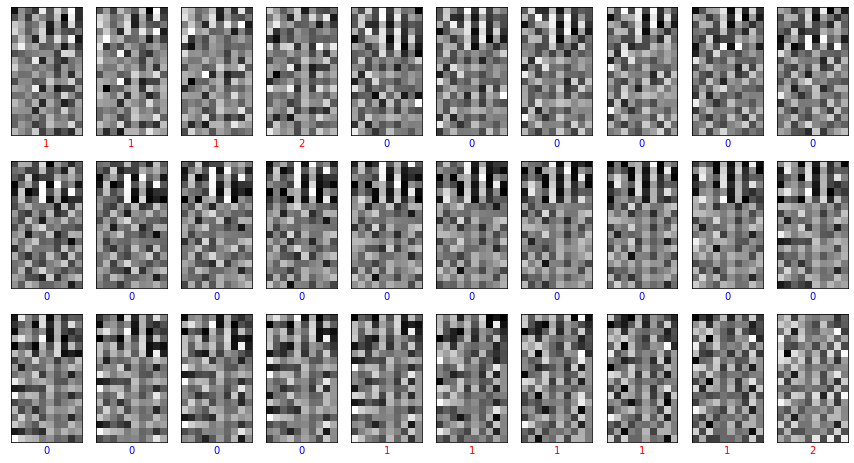

In [20]:
# Compare results in a display of images
colr = ['blue', 'red']
print('x_test image and label')
plt.figure(figsize=(15,8))
for i in range(190,220):
    plt.subplot(3,10,i-189)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
    plt.xlabel(Y[i], c=colr[1*(Y[i]>0)]) 
plt.show()

In [21]:
# Save a viewable copy of x_test to disply results
x_te = images_t

In [22]:
# Reshape the image array for CNN input

images = images.reshape(373, 18, 10, 1)
images_t = images_t.reshape(373, 18, 10, 1)

### Build a CNN Classification model with 3 output classes 0 to 2.

In [23]:
from keras import Sequential, regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


Using TensorFlow backend.


In [24]:
# Build Model

model = Sequential()
model.add(Conv2D(4, (3,3), input_shape = (18, 10, 1),  activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
live_plot = livelossplot.PlotLossesKeras()

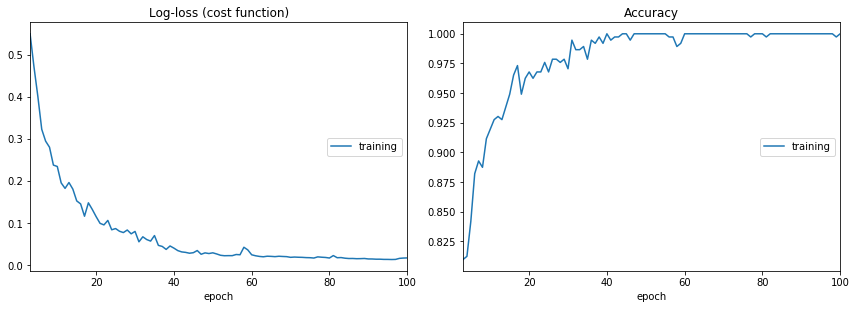

Log-loss (cost function):
training   (min:    0.013, max:    0.667, cur:    0.017)

Accuracy:
training   (min:    0.764, max:    1.000, cur:    1.000)


In [26]:
# Fit the model & train for 100 epochs initially, livelossplot in callbacks, 

model.fit(images, Y, callbacks = [live_plot], initial_epoch = 0, epochs = 100, batch_size = 10)

In [27]:
# Put results value in y_pred
y_pred = model.predict(images_t).argmax(axis=1)
y_prob = model.predict_proba(images_t)

### The prediction above gives an early indication of a fault.


x_test image and prediction: Yes / No - Prediction matches Class, Partly - Prediction and Actual are > 0


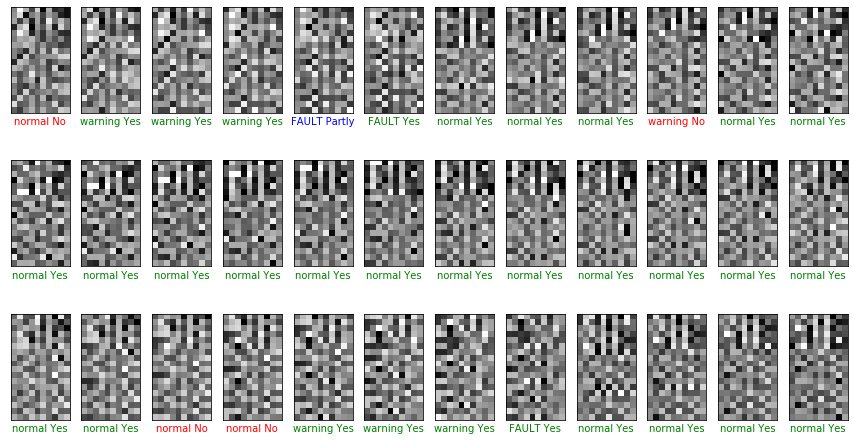

In [28]:
# Compare results in a display of 15 images from index 180 to 216
j=176 #(offset to view subset)
class_labels = ['normal','warning', 'FAULT']
correct = ['No', 'Yes','Yes','Partly']
col_r = ['r', 'g', 'g', 'blue']
print('\nx_test image and prediction: Yes / No - Prediction matches Class, Partly - Prediction and Actual are > 0')
plt.figure(figsize=(15,8))
for i in range(4,40):
    plt.subplot(3,12,i-3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_te[i+j], cmap='gray')
    val_p = int(y_pred[i+j])
    val_a = int(Yt[i+j])
    correctness = 0 + 1*(val_p==0 and val_a== 0) + 2*(val_a>0)*(val_p==val_a) + 3*(val_a>0)*(val_p>0)*(val_p!=val_a)
    lab_l = (class_labels[val_a])
    plt.xlabel(class_labels[y_pred[i+j]]+' '+str(correct[correctness]), c = col_r[correctness])
plt.show()



#### Conceptually this approach works and may be able to provide early warning of fault not indicated by current operating sensor values.

#### Plot the Test set prediction results.

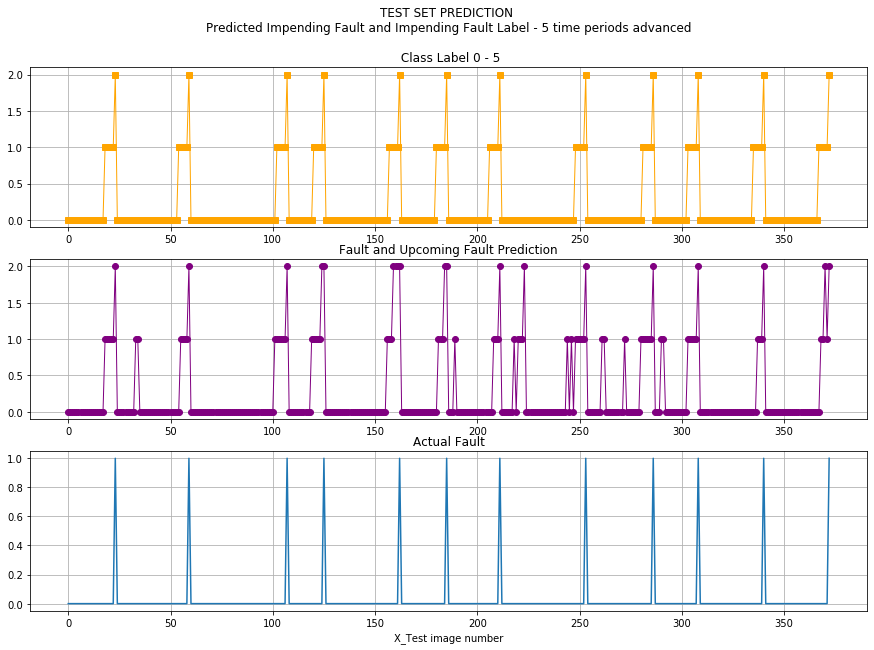

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,10))
ax1.plot(Yt[Yt<6], label = "Class Label 0 to 5", ls = '-', lw = 1, c ='orange', marker = 's')
ax2.plot(y_pred, label ="Class Prediction", c ='purple', lw = 1, marker='o')
ax1.set_title('TEST SET PREDICTION \nPredicted Impending Fault and Impending Fault Label - 5 time periods advanced\n\n Class Label 0 - 5')
ax2.set_title('Fault and Upcoming Fault Prediction')
ax3.plot(lblt)
ax3.set_title("Actual Fault")
ax1.grid()
ax2.grid()
ax3.grid()
ax3.set_xlabel('X_Test image number')
plt.show()

#### The Test results show multiple warnings ahead of all of 12 failures. The confusion matrix and classification report are below. The results are better than the case ran with 5 warning classes.  Note that some of the normal samples were classified as a warning state.  In fact the synthetic data did include excursions that did not reach a failure and these are labelled as normal ( 0 ), in both the training and test sets.  Much as would happen in real systems.


In [30]:
print('CNN Model X Test Confusion Matrix\n', confusion_matrix(Yt, y_pred))

CNN Model X Test Confusion Matrix
 [[282  18   1]
 [  7  47   6]
 [  0   0  12]]


In [31]:
print('CNN Classification Report\n', classification_report(Yt, y_pred))

CNN Classification Report
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       301
           1       0.72      0.78      0.75        60
           2       0.63      1.00      0.77        12

    accuracy                           0.91       373
   macro avg       0.78      0.91      0.83       373
weighted avg       0.92      0.91      0.92       373



In [32]:
model.save("Simulated_process_w_vel_acc_3class.h5")